# Allen atlas image regression

## 1. Opening AllenSDK, Packages and Isocortex map

In [1]:
import numpy as np
import os
import functools
import time
from pathlib import Path
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
from MIFFE import search_path
import ants
import nrrd
import scipy
import cv2
from PIL import Image
import nrrd
from collections import OrderedDict
import tifffile as tiff
from scipy.signal import medfilt
import time

2023-09-11 15:05:56.847272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# REGISTRATION_PATH is the folder in which every surgery image will be put under the folder associated with a 
# specific mouse. The folder is named after the mouse ID like so : registration_folder_path / M38 / Surgery.png .

# DATA_PATH is the path directly to the .tif data file.

reg_path = '/Users/vincentchouinard/Documents/Maitrise/Registration/M38'
data_folder = '/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout'
data_file = '/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Correction/corrected_green_movie.tif'

%matplotlib qt

In [4]:
registration(reg_path, data_folder, data_file, overwrite = False, display_first = False)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2573.05it/s]


Cortical map obtained.
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.
Folder named "/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Registration_files" already exists.
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.
Done!


# List of functions that are needed for the main function to run properly :

In [2]:
def obtain_cortical_map(structure='Isocortex'):
    rsp, tree = open_AllenSDK()
    isocortex_map, id_name_dict, _ = map_generator(rsp, tree, structure='Isocortex')
    print('Cortical map obtained.')
    return isocortex_map, id_name_dict

In [3]:
def create_folder(folder_path, new_folder_name):
    new_folder_path = "".join([folder_path,  '/', str(new_folder_name)])
    new_folder_path = Path(new_folder_path)

    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)
        print('New folder named "{}" was created.'.format(new_folder_path))
    else:
        print('Folder named "{}" already exists.'.format(new_folder_path))  
        
    return str(new_folder_path)

In [4]:
def overlay(img1, img2):
    # Create a window to display the images
    cv2.namedWindow('Image')

    # Initialize variables
    x_offset = 0
    y_offset = 0
    scale_percent = 100
    dragging = False
    resizing = False
    corner_size = 20
    update_needed = True

    # Define the mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal x_offset, y_offset, scale_percent, dragging, resizing, update_needed

        if event == cv2.EVENT_LBUTTONDOWN:
            if x > x_offset - corner_size and x < x_offset + corner_size and y > y_offset - corner_size and y < y_offset + corner_size:
                resizing = True
            else:
                dragging = True
        elif event == cv2.EVENT_MOUSEMOVE:
            if dragging or resizing:
                update_needed = True
                if dragging:
                    x_offset += x - param[0]
                    y_offset += y - param[1]
                elif resizing:
                    scale_percent += (x - param[0]) / 10
        elif event == cv2.EVENT_LBUTTONUP:
            dragging = False
            resizing = False

        param[0] = x
        param[1] = y

    # Set the mouse callback function
    cv2.setMouseCallback('Image', mouse_callback, [0, 0])

    while True:
        if update_needed:
            # Resize img2
            width = int(img2.shape[1] * scale_percent / 100)
            height = int(img2.shape[0] * scale_percent / 100)
            dim = (width, height)
            resized_img2 = cv2.resize(img2, dim, interpolation=cv2.INTER_AREA)

            # Create the overlay image
            overlay = img1.copy()
            overlay[y_offset:y_offset + resized_img2.shape[0], x_offset:x_offset + resized_img2.shape[1]] = \
            cv2.addWeighted(overlay[y_offset:y_offset + resized_img2.shape[0], x_offset:x_offset + resized_img2.shape[1]], 0.5, resized_img2, 0.5, 0)

            # Draw the dots at the corners
            cv2.circle(overlay, (x_offset, y_offset), 5, (0, 0, 0), -1)

            # Show the image
            cv2.imshow('Image', overlay)
            update_needed = False

        # Break the loop when the 'q' key is pressed
        if cv2.waitKey(20) & 0xFF == 27:
            break

    # Release the resources and close the window
    cv2.destroyAllWindows()
    
    return x_offset, y_offset, scale_percent

In [5]:
def crop_and_rescale(transformed_img, reference_img, x_offset, y_offset, scale_percent):
    # rescales images that are transformed and adjusted to masks in 1378 by 1208. That function goes in 
    # conjunction with the overlay function. reference_img is the wanted final dimensions. It is necessary
    # to have to descale.
    
    # calculate the new dimensions of the image
    upsized_width = int(reference_img.shape[1] * scale_percent / 100)
    upsized_height = int(reference_img.shape[0] * scale_percent / 100)
    upsized_dim = (upsized_width, upsized_height)
    
    # crops leftmost band and uppermost band to have no more offset.
    cropped_img = transformed_img[y_offset : y_offset+upsized_height , x_offset : x_offset+upsized_width]

    # rescales the image
    width = reference_img.shape[1]
    height = reference_img.shape[0]
    
    dim = (width, height)
    
    resized_img = cv2.resize(cropped_img, dim, interpolation = cv2.INTER_LINEAR)
    resized_img[resized_img > 0] = 1
    
    return resized_img

In [6]:
def ants_transformation(ants_surgery_mask, ants_isocortex_mask):

    # Perform Rigid Registration
    rigid = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                              type_of_transform='Rigid',
                              reg_iterations=(200, 200, 200, 10),
                              aff_iterations=(200, 200, 200, 10),
                              aff_shrink_factors=(12, 8, 4, 2),
                              aff_smoothing_sigmas=(4, 3, 2, 1),
                              metric='MI')

    # Perform Affine Registration
    affine = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                               initial_transform=rigid['fwdtransforms'][0],
                               type_of_transform='Affine',
                               reg_iterations=(200, 200, 200, 10),
                               aff_shrink_factors=(8, 4, 2, 1),
                               aff_smoothing_sigmas=(4, 3, 2, 1),
                               metric='MI')

    # Perform SyN Registration
    syn = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                            initial_transform=affine['fwdtransforms'][0],
                            type_of_transform='SyNOnly',
                            reg_iterations=(200, 200, 200, 200, 100, 10, 5),
                            metric='CC')
    
    return syn

In [7]:
def change_nrrd_headers(reg_files_path, res_fact):
    
    data1, header1 = nrrd.read(reg_files_path + '/surgery_mask.nrrd')

    header1 = OrderedDict([('type', 'uint8'),
                 ('dimension', 2),
                 ('space dimension', 2),
                 ('sizes', np.array([1378, 1208])),
                 ('space directions',
                  np.array([[round(25./res_fact,2), 0. ],
                         [0. , round(25./res_fact,2)]])),
                 ('encoding', 'raw'),
                 ('space units', ['microns', 'microns'])])

    nrrd.write(reg_files_path + '/surgery_mask.nrrd', data1, header1)

    data2, header2 = nrrd.read(reg_files_path + '/isocortex_mask.nrrd')

    header2 = OrderedDict([('type', 'uint8'),
                 ('dimension', 2),
                 ('space dimension', 2),
                 ('sizes', np.array([456, 528])),
                 ('space directions',
                  np.array([[25.,  0. ],
                         [ 0. , 25.]])),
                 ('encoding', 'raw'),
                 ('space units', ['microns', 'microns'])])

    nrrd.write(reg_files_path + '/isocortex_mask.nrrd', data2, header2)

In [8]:
# data_folder = '/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout'
# reg_files_path = create_folder(data_folder , 'Registration_files')

# # SAVES the mask in .tif
# surgery_mask_name = 'surgery_mask'
# npy_to_tif(surgery_mask, surgery_mask_name, path=reg_files_path)

# # SAVES isocortex_mask in .tif
# isocortex_mask_name = 'isocortex_mask'
# npy_to_tif(isocortex_mask, isocortex_mask_name, path=reg_files_path)

# # SAVES contour in .tif
# contour_name = 'contour'
# npy_to_tif(contour, contour_name, path=reg_files_path)

# # SAVES everything as .nrrd
# im3 = cv2.imread(str(reg_files_path) + '/isocortex_mask.tif', cv2.IMREAD_GRAYSCALE)
# nrrd.write(str(reg_files_path) + "/isocortex_mask.nrrd", im3)

# im4 = cv2.imread(str(reg_files_path) + '/surgery_mask.tif', cv2.IMREAD_GRAYSCALE)
# nrrd.write(str(reg_files_path) + "/surgery_mask.nrrd", im4)

# im5 = cv2.imread(str(reg_files_path) + '/contour.tif', cv2.IMREAD_GRAYSCALE)
# nrrd.write(str(reg_files_path) + "/contour.nrrd", im5)

In [9]:
def mask_folder(data_folder , ants_surgery_mask , adjusted_brain_mask , window_image , overlay_parameters , isocortex_map , mask_list , transform , overwrite = False):

    #Creates a folder in which movie is transformed to
    mask_folder_name = 'Masks'
    new_mask_path = "".join([data_folder,  '/', mask_folder_name])
    new_mask_path = Path(new_mask_path)

    if not os.path.exists(new_mask_path):
        os.makedirs(new_mask_path)

    new_mask_list = []
    masks = []
    
    for i in mask_list:
        if i != 0:
            file_path = new_mask_path / f'mask_{int(i)}.npy'
            if file_path.exists() and not overwrite:
                print(f"File {file_path} already exists and overwrite is set to False. Skipping.")
                continue
                
            mask = create_mask(isocortex_map, i)
            mask[mask != 0] = 1
            ants_mask = ants.from_numpy(mask, spacing=(25.,25.))
            transformed_mask = ants.apply_transforms(fixed=ants_surgery_mask,
                                                  moving=ants_mask,
                                                  transformlist=transform['fwdtransforms'])

            transformed_mask = transformed_mask*adjusted_brain_mask

            if len(np.unique(transformed_mask.numpy())) > 1:

                new_mask_list.append(int(i))
                numpy_transformed_mask = transformed_mask.numpy()
                numpy_transformed_mask[numpy_transformed_mask != 0] = 1

                # resize transformed_mask on right scale (the window scale):
                x_offset, y_offset, scale_percent = overlay_parameters
                resized_transformed_mask = crop_and_rescale(numpy_transformed_mask, window_image, x_offset, y_offset, scale_percent)
                
                
                # Adds the transformed mask to a list of masks that are not yet adjusted to not overlap.
                masks.append(resized_transformed_mask)
            else:
                continue
    
    # Obtains the overlap_map of all different transformed regions and segments them to assure no
    # overlapping.
    
    no_overlap_map = np.zeros((window_image.shape[0],window_image.shape[1]))
    
    for i in range(len(masks)):
        mask = masks[i]
        no_overlap_map += mask
        
    no_overlap_map[no_overlap_map > 1] = 0
    
    
    for i, mask_id in enumerate(new_mask_list):
        mask = masks[i]*no_overlap_map
        tiff.imwrite(str(new_mask_path) + '/mask_{}.tif'.format(int(mask_id)), mask)
            
    print('Done!')
    return None

In [10]:
def resolution_factor(norm_mask, comp_mask):
    # gives resolution_factor between two different dimension masks
    
    def widest_row(mask):
        widest = 0
        n = 0
        for i in range(mask.shape[0]):
            nonzero_count = np.count_nonzero(mask[i,:])
            if np.count_nonzero(mask[i,:]) > n:
                widest = i
                n = nonzero_count
        return widest, n
    
    _, norm = widest_row(norm_mask)
    _, comp = widest_row(comp_mask)
    return norm/comp

# The official registration function

In [11]:
def registration(registration_path, data_folder, data_file, display_first = False):
    '''
    REGISTRATION_PATH is the folder in which every surgery image will be put under the folder associated with a 
    specific mouse. The folder is named after the mouse ID like so : registration_folder_path / M38 / Surgery.png .
    DATA_FOLDER is the path to the data experiment folder.
    DATA_FILE is the path to the data experiment file (.tif format).
    
    '''
    %matplotlib qt
    
    
    # outputs a cortical map of the allen institute 2017 annotation. Every id in the map are in mask_list.
    isocortex_map, id_name_dict = obtain_cortical_map()
    mask_list = list(id_name_dict.keys())
    
    # outputs the mask of the allen isocortex
    isocortex_mask = create_mask(isocortex_map, mask_list)
    
    # obtain the surgery mask
    
    img_list = identify_files(registration_path, keywords=['.jpg'])
    if len(img_list)>1:
        raise Exception("Sorry, only the cortical_surgery_image.jpg is supposed to be in '{}'. ".format(str(registration_path)))
    else:
        surgery_image = cv2.imread(registration_path + '/' + img_list[0])
    
    # SELECTS A MASK and outputs a binary npy

    surgery_mask = select_mask(np.copy(surgery_image))
    
    
    # Creates a folder named Registration_files inside of data_folder. Registration_files will regroup every 
    # item used for the registration process.
    
    reg_files_path = create_folder(data_folder , 'Registration_files')
    
    # SAVES the mask in .tif
    surgery_mask_name = 'surgery_mask'
    npy_to_tif(surgery_mask, surgery_mask_name, path=reg_files_path)

    # SAVES isocortex_mask in .tif
    isocortex_mask_name = 'isocortex_mask'
    npy_to_tif(isocortex_mask, isocortex_mask_name, path=reg_files_path)

    # SAVES everything as .nrrd
    im3 = cv2.imread(reg_files_path + '/isocortex_mask.tif', cv2.IMREAD_GRAYSCALE)
    nrrd.write(reg_files_path + "/isocortex_mask.nrrd", im3)

    im4 = cv2.imread(reg_files_path + '/surgery_mask.tif', cv2.IMREAD_GRAYSCALE)
    nrrd.write(reg_files_path + "/surgery_mask.nrrd", im4)

    
    # 1st registration step: registers isocortex_mask vs surgery_mask with ANTSpy
    res_fact = resolution_factor(surgery_mask, isocortex_mask)
    
    change_nrrd_headers(reg_files_path, res_fact)
    ants_surgery_mask = ants.image_read(reg_files_path + "/surgery_mask.nrrd")
    ants_isocortex_mask = ants.image_read(reg_files_path + "/isocortex_mask.nrrd")
    transform = ants_transformation(ants_surgery_mask, ants_isocortex_mask)
    
    if display_first:
        # Apply Transforms
        warped_isocortex_mask = ants.apply_transforms(fixed=ants_surgery_mask,
                                                      moving=ants_isocortex_mask,
                                                      transformlist=transform['fwdtransforms'])
        
        fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
        plt.imshow(warped_isocortex_mask.numpy(), alpha=0.5, cmap='Reds')
        plt.imshow(ants_surgery_mask.numpy(), alpha=0.5, cmap='Blues')
        plt.show()
        
        
    
    # 2nd registration step: Overlays surgery image and data on one another ton link them by a transform.
        
    window_layer = cv2.imread(data_file)
    window_layer, _ , _ = intensity_bounds(window_layer)
    
    # overlay_parameters is a tuple of x_offset, y_offset and scale_percent parameters for the mask_folder function.
    overlay_parameters = overlay(surgery_image, window_layer)
    
    # Creates a brain mask that will crop masks to only include regions inside the brain window.
    
    brain_mask = select_mask(np.copy(window_layer), colorline = 'red')
    
    x_offset, y_offset, scale_percent = overlay_parameters
    width = int(window_layer.shape[1] * scale_percent / 100)
    height = int(window_layer.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(brain_mask, dim, interpolation = cv2.INTER_LINEAR)

    adjusted_brain_mask = np.zeros((surgery_mask.shape[0], surgery_mask.shape[1]))
    adjusted_brain_mask[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized[:,:]

    mask_folder(data_folder, ants_surgery_mask , adjusted_brain_mask , window_layer , overlay_parameters , isocortex_map, mask_list, transform, overwrite = False)

# Development steps of the pipeline

In [10]:
experiment_name = "RS_M38_22aout"

In [5]:
#directory = search_for_file_path()
rsp, tree = open_AllenSDK() #resolution of annotation can be changed with karg resolution. default = 25 micrometer
isocortex_map, id_name_dict, bregma = map_generator(rsp, tree, structure='Isocortex')

#sma_mask = create_mask(isocortex_map, 656)
contour = create_contour(isocortex_map)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2320.58it/s]


## 2. Plotting regions and contours for open_AllenSDK validation

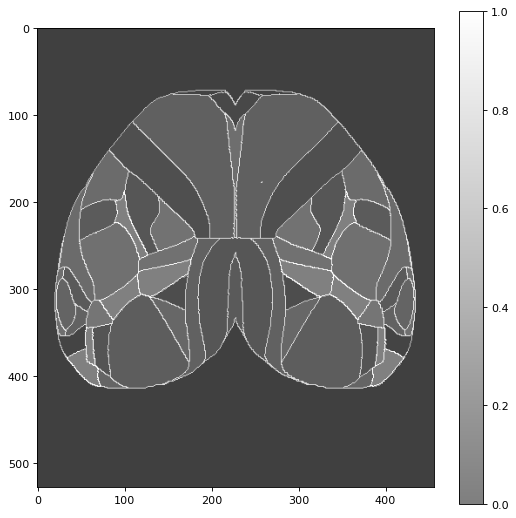

In [12]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
plt.imshow(isocortex_map,vmax=1300, cmap='gray', alpha=0.5)
plt.imshow(contour, cmap='binary_r', alpha=0.5)
plt.colorbar()
plt.show()

## 3. Changing to local directory to save images and automate process

#### (Also creates a new folder named experiment_name if it does not exist yet)

In [14]:
# Changing directory for local_dir (where every registration will be made)
local_dir='/Users/vincentchouinard/Documents/Maitrise/Registration'
os.chdir(local_dir)


newfolderpath = "".join([local_dir,  '/', experiment_name])
newfolderpath = Path(newfolderpath)

if not os.path.exists(newfolderpath):
    os.makedirs(newfolderpath)
    print('New folder named "{}" was created: Add picture(s) to the folder for the registration process.'.format(newfolderpath))

# Changing directory to newfolderpath
os.chdir(newfolderpath)

## 4. Create isocortex Mask

In [47]:
mask_list = list(id_name_dict.keys())
isocortex_mask = create_mask(isocortex_map, mask_list)

print('List of IDs in the cortex map imported from Allen  :  ', mask_list)

List of IDs in the cortex map imported from Allen  :   [68, 97, 171, 281, 320, 421, 442, 450, 484, 527, 542, 558, 593, 656, 671, 696, 735, 750, 805, 836, 873, 878, 897, 935, 959, 981, 1006, 1030, 1074, 182305693, 312782550, 312782578, 312782604, 312782632]


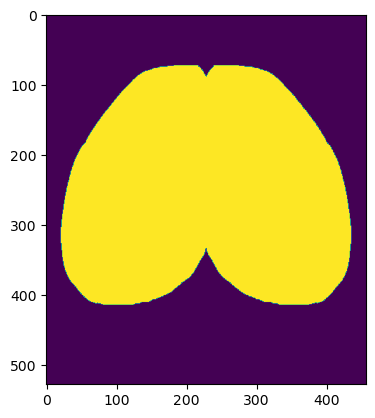

In [48]:
plt.imshow(isocortex_mask)

## 5. Creates surgery_mask, saves both isocortex_mask / surgery_mask / contour in .tif

In [10]:
# Gets the right PATH for surgery_image

surgery_image_path = search_path(path_type='file')
surgery_image_path = Path(surgery_image_path)


# SELECTS A MASK and outputs a binary npy
%matplotlib qt


surgery_image = cv2.imread(str(surgery_image_path))
surgery_mask = select_mask(surgery_image)

You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/RS_M38_22aout/surgery.jpg
Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


In [11]:
# SAVES the mask in .tif

surgery_mask_name = 'surgery_mask'
npy_to_tif(surgery_mask, surgery_mask_name, path=surgery_image_path.parents[0])


# SAVES isocortex_mask in .tif

isocortex_mask_name = 'isocortex_mask'
npy_to_tif(isocortex_mask, isocortex_mask_name, path=surgery_image_path.parents[0])


# SAVES contour in .tif

contour_name = 'contour'
npy_to_tif(contour, contour_name, path=surgery_image_path.parents[0])

## 5.2 Measure resolution factor between isocortex (Allen) and surgery (picture) masks

In [6]:
def widest_row(mask):
    widest = 0
    n = 0
    for i in range(mask.shape[0]):
        nonzero_count = np.count_nonzero(mask[i,:])
        if np.count_nonzero(mask[i,:]) > n:
            widest = i
            n = nonzero_count
    return widest, n

def resolution_factor(norm_mask, comp_mask):
    # gives resolution_factor between two different dimension masks
    _, norm = widest_row(norm_mask)
    _, comp = widest_row(comp_mask)
    return norm/comp

# This will be used to guide the registration for big gaps pixel dimensions
res_fact = resolution_factor(surgery_mask, isocortex_mask)

NameError: name 'surgery_mask' is not defined

## 6. Creates .nrrd files

In [13]:
%matplotlib inline

In [15]:
# Find paths here. Remember that the working directory is already "experiment_name", so only file name is
# necessary. 
search = False

surgeryPath = str(surgery_image_path)
windowPath = "/Users/vincentchouinard/Documents/Maitrise/Registration/test1_M36/PXL_20230426_214623942.jpg"

if search:
    surgeryPath = search_path(path_type="file")
    windowPath = search_path(path_type="file")

#### all nrrd files to write

In [19]:
im = cv2.imread(surgeryPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_image.nrrd",im)

im2 = cv2.imread(windowPath, cv2.IMREAD_GRAYSCALE)
nrrd.write("window_image.nrrd", im2)

im3 = cv2.imread(reg_files_path + '/isocortex_mask.tif', cv2.IMREAD_GRAYSCALE)
nrrd.write(isocortex_mask.nrrd", im3)

im4 = cv2.imread(reg_files_path + '/surgery_mask.tif', cv2.IMREAD_GRAYSCALE)
nrrd.write("surgery_mask.nrrd", im4)

im5 = cv2.imread("contour.tif", cv2.IMREAD_GRAYSCALE)
nrrd.write("contour.nrrd", im5)

## Checkup of nrrd headers

#### Let's hardcode a Header to test multiple space directions

In [52]:
res_fact = 2.57  #for tests

In [53]:
data1, header1 = nrrd.read('surgery_mask.nrrd')

header1 = OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', np.array([1378, 1208])),
             ('space directions',
              np.array([[round(25./res_fact,2), 0. ],
                     [0. , round(25./res_fact,2)]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

nrrd.write('surgery_mask.nrrd', data1, header1)

In [54]:
data2, header2 = nrrd.read('isocortex_mask.nrrd')

header2 = OrderedDict([('type', 'uint8'),
             ('dimension', 2),
             ('space dimension', 2),
             ('sizes', np.array([456, 528])),
             ('space directions',
              np.array([[25.,  0. ],
                     [ 0. , 25.]])),
             ('encoding', 'raw'),
             ('space units', ['microns', 'microns'])])

nrrd.write('isocortex_mask.nrrd', data2, header2)

## 7. Opening masks and finding transform

In [8]:
ants_surgery_mask = ants.image_read("surgery_mask.nrrd")
ants_isocortex_mask = ants.image_read("isocortex_mask.nrrd")

In [9]:
def ants_transformation(antssurgerymask, antsisocortexmask):

    # Perform Rigid Registration
    rigid = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                              type_of_transform='Rigid',
                              reg_iterations=(200, 200, 200, 10),
                              aff_iterations=(200, 200, 200, 10),
                              aff_shrink_factors=(12, 8, 4, 2),
                              aff_smoothing_sigmas=(4, 3, 2, 1),
                              metric='MI')

    # Perform Affine Registration
    affine = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                               initial_transform=rigid['fwdtransforms'][0],
                               type_of_transform='Affine',
                               reg_iterations=(200, 200, 200, 10),
                               aff_shrink_factors=(8, 4, 2, 1),
                               aff_smoothing_sigmas=(4, 3, 2, 1),
                               metric='MI')

    # Perform SyN Registration
    syn = ants.registration(fixed=ants_surgery_mask, moving=ants_isocortex_mask,
                            initial_transform=affine['fwdtransforms'][0],
                            type_of_transform='SyNOnly',
                            reg_iterations=(200, 200, 200, 200, 100, 10, 5),
                            metric='CC')
    
    return syn

# Apply Transforms
warped_isocortex_mask = ants.apply_transforms(fixed=ants_surgery_mask,
                                              moving=ants_isocortex_mask,
                                              transformlist=syn['fwdtransforms'])

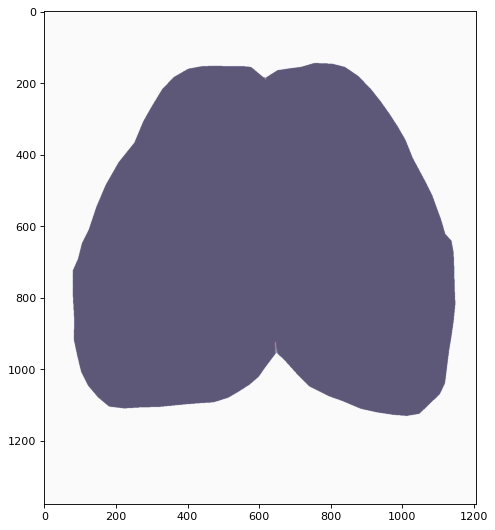

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
plt.imshow(warped_isocortex_mask.numpy(), alpha=0.5, cmap='Reds')
plt.imshow(ants_surgery_mask.numpy(), alpha=0.5, cmap='Blues')
plt.show()

In [12]:
def compute_iou(image1, image2):
    # Computes the intersection over union of two images. 
    
    # Ensure the images are the same size
    assert image1.shape == image2.shape
    
    # Define the intersection and union
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [13]:
compute_iou(warped_isocortex_mask.numpy(), ants_surgery_mask.numpy())

0.9938202612639784

## Tests pour warp les contours

In [171]:
ants_contour = ants.from_numpy(contour, spacing=(25.,25.))
ants_surgery_image = ants.image_read("surgery_image.nrrd")
warped_contour = ants.apply_transforms(ants_surgery_mask, ants_contour, mytx['fwdtransforms'])

In [175]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=80)

plt.imshow(warped_contour.numpy(), alpha=0.5)
plt.imshow(ants_surgery_image.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

# 2nd part of registration with landmarks

In [11]:
# Gets the right PATHs

surgery_image_path = search_path(path_type='file')
surgery_image_path = Path(surgery_image_path)

window_image_path = search_path(path_type='file')
window_image_path = Path(window_image_path)

# cv2.imread only takes the first image if it is given an image stack. So it's perfect
# for obtaining window_image straight from the stack.
surgery_image = cv2.imread(str(surgery_image_path), cv2.IMREAD_GRAYSCALE)
window_image = cv2.imread(str(window_image_path), cv2.IMREAD_GRAYSCALE)

You chose: /Users/vincentchouinard/Documents/Maitrise/Registration/RS_M38_22aout/surgery.jpg
You chose: /Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Correction/corrected_green_movie.tif


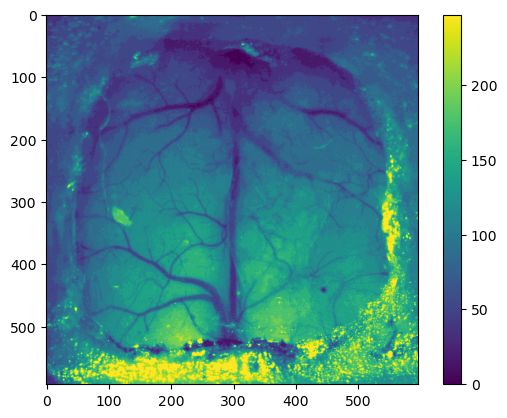

In [12]:
window_image , _ , _ = intensity_bounds(window_image)
plt.imshow(window_image)
plt.colorbar()

In [9]:
%matplotlib qt

In [10]:
def select_labels(left_image, right_image):
    
    # Autocrops window_image vertically so it works when concatenated with surgery_image

    if left_image.shape[0] - right_image.shape[0] < 0:
        surplus = abs(left_image.shape[0] - right_image.shape[0])
        right_image = right_image[int(np.ceil(surplus/2)):int(-np.floor(surplus/2)),:]
    
    def fit_image_rows(image, target_image):
        
        # Get the number of rows to add
        rows_to_add = target_image.shape[0] - image.shape[0]

        # Check if the image already has the target number of rows
        if rows_to_add == 0:
            return image

        # Check if the image has more rows than the target
        if rows_to_add < 0:
            raise ValueError("Image already has more rows than the target")

        # Get the number of columns and channels in the image
        cols = image.shape[1]

        # Create a blank image with the same number of columns and channels as the image
        blank_image = np.zeros((rows_to_add, cols), dtype=image.dtype)

        # Concatenate the image and the blank image vertically
        augmented_image = np.vstack((image, blank_image))

        return augmented_image
    
    def intensity_bounds(im, kernelsize=11, percentile=0.01):
        # Removes pixel intensity aberations, finds optimized bounds for a certain image. kernelsize is for filter
        # and percentile is to determine what's the intensity threshold of a normalized intensity distribution.
        flat = im.flatten()
        flat = medfilt(flat, kernel_size=kernelsize)
        min_range, max_range = np.min(flat), np.max(flat)
        flat_mean, flat_std = np.mean(flat), np.std(flat)

        def gaussian(x, mean, std):
            return np.exp(-(x - mean) ** 2 / (2 * std ** 2))

        x = np.linspace(min_range, max_range, 1000)
        y = gaussian(x, flat_mean, flat_std)

        value_range = np.where(y > percentile)

        vmin = value_range[0][0]
        vmax = x[value_range[0][-1]]

        return vmin, vmax
    
    
    if left_image.shape[0] - right_image.shape[0] > 0:
        elongated_right_image = fit_image_rows(right_image, left_image)

    hori = np.concatenate((left_image, elongated_right_image), axis=1)

    print(
        'Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.')
    # Initialize variables
    label_points = []
    label_completed = False

    def mouse_callback(event, x, y, flags, param):
        nonlocal label_points, label_completed

        if event == cv2.EVENT_LBUTTONDOWN:
            label_points.append((x, y))
            cv2.circle(hori, (x, y), 4, (0, 0, 0), -1)
            


    # Create a window to display the image
    cv2.namedWindow('Select Labels')
    cv2.imshow('Select Labels', hori)

    # Register the mouse callback function
    cv2.setMouseCallback('Select Labels', mouse_callback)
    while not label_completed:
        cv2.imshow('Select Labels', hori)
        key = cv2.waitKey(10)

        if key == 27:
            label_completed = True

    # Convert the ROI points to a NumPy array
    label_points = np.array(label_points)
    
    if left_image.ndim > 2:
        return print("Images inputed are in RGB, we need them greyscale. Load them with 'cv2.IMREAD_GRAYSCALE'.")

    # Create a binary mask
    
    left_mask = np.zeros_like(left_image, dtype=np.uint8)
    right_mask = np.zeros_like(right_image, dtype=np.uint8)

    left_labellist = []
    right_labellist = []
    
    for label in label_points:
        if left_image.shape[1] < label[0]:
            right_mask[label[1],label[0]-left_image.shape[1]] = 1
            label[0] = label[0] - left_image.shape[1]
            right_labellist.append(label)
            
        else:
            left_mask[label[1],label[0]] = 1
            left_labellist.append(label)

    right_labels = np.array(right_labellist)
    left_labels = np.array(left_labellist)

    cv2.destroyWindow('Select Labels')
    cv2.destroyAllWindows()
    
    return left_mask, right_mask, left_labels, right_labels

In [11]:
reference_mask, adjusted_mask, surgery_labels, window_labels = select_labels(surgery_image, window_image)

Press "escape" to exit when cropping is done. First and last selected coordinates will automatically connect.


In [84]:
from scipy.ndimage import binary_dilation

structuring_element = np.ones((50,50), dtype=np.uint8)

dilated_ref = binary_dilation(reference_mask, structure=structuring_element)

In [85]:
from scipy.ndimage import binary_dilation

structuring_element = np.ones((50,50), dtype=np.uint8)

dilated_adj = binary_dilation(adjusted_mask, structure=structuring_element)

In [86]:
%matplotlib inline

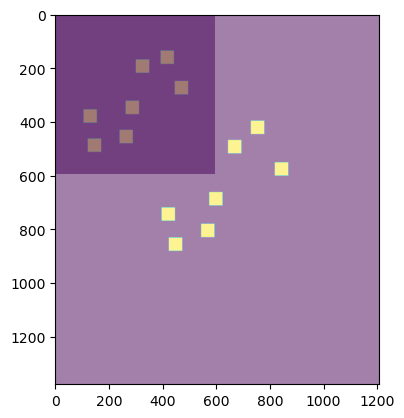

In [87]:
plt.imshow(dilated_adj, alpha=0.5)
plt.imshow(dilated_ref, alpha=0.5)
plt.show()

### (Ici j'ai échangé adjusted avec reference pcq on veut chirurgie vers window et non l'inverse, j'avais gardé le fixed à chirurgie par habitude mais c'est con)

In [88]:
ants_adjusted_mask = ants.from_numpy(dilated_ref.astype(np.uint8))
ants_reference_mask = ants.from_numpy(dilated_adj.astype(np.uint8))

In [91]:
# Perform Rigid Registration
rigid3 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                          type_of_transform='Rigid',
                          reg_iterations=(200, 200, 200, 10),
                          aff_iterations=(200, 200, 200, 10),
                          aff_shrink_factors=(12, 8, 4, 2),
                          aff_smoothing_sigmas=(4, 3, 2, 1),
                          metric='Meansquares')

# Perform Affine Registration
affine3 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                           initial_transform=rigid3['fwdtransforms'][0],
                           type_of_transform='Affine',
                           reg_iterations=(200, 200, 200, 10),
                           aff_shrink_factors=(8, 4, 2, 1),
                           aff_smoothing_sigmas=(4, 3, 2, 1),
                           metric='CC')

# Perform SyN Registration
syn3 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                        initial_transform=affine3['fwdtransforms'][0],
                        type_of_transform='SyNOnly',
                        reg_iterations=(200, 200, 200, 200, 100, 10, 5),
                        metric='CC')

# Apply Transforms
warped_window = ants.apply_transforms(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                                              transformlist=syn3['fwdtransforms'])

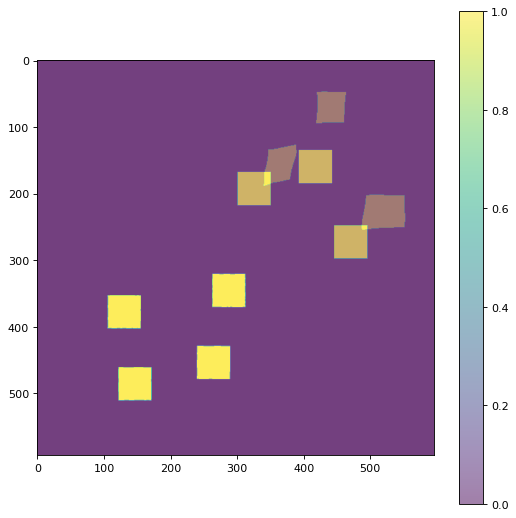

In [92]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(warped_window.numpy(), alpha=0.5)
plt.imshow(ants_reference_mask.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

In [53]:
ants_adjusted_mask = ants.from_numpy(dilated_ref.astype(np.uint8))
ants_reference_mask = ants.from_numpy(dilated_adj.astype(np.uint8))

In [51]:
# Perform Rigid Registration
rigid2 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                          type_of_transform='Rigid',
                          reg_iterations=(200, 200, 200, 10),
                          aff_iterations=(200, 200, 200, 10),
                          aff_shrink_factors=(12, 8, 4, 2),
                          aff_smoothing_sigmas=(4, 3, 2, 1),
                          metric='MI')

# Perform Affine Registration
affine2 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                           initial_transform=rigid2['fwdtransforms'][0],
                           type_of_transform='Affine',
                           reg_iterations=(200, 200, 200, 10),
                           aff_shrink_factors=(8, 4, 2, 1),
                           aff_smoothing_sigmas=(4, 3, 2, 1),
                           metric='MI')

# Perform SyN Registration
syn2 = ants.registration(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                        initial_transform=affine2['fwdtransforms'][0],
                        type_of_transform='SyN',
                        reg_iterations=(200, 200, 200, 200, 100, 10, 5),
                        metric='CC')

# Apply Transforms
warped_window = ants.apply_transforms(fixed=ants_reference_mask, moving=ants_adjusted_mask,
                                              transformlist=syn2['fwdtransforms'])

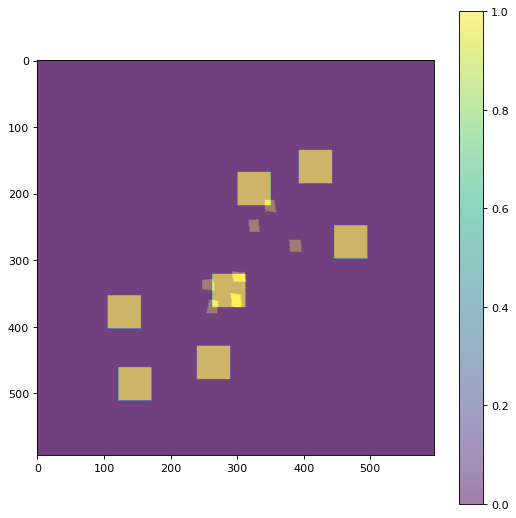

In [52]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(warped_window.numpy(), alpha=0.5)
plt.imshow(ants_reference_mask.numpy(), alpha=0.5)
plt.colorbar()
plt.show()

In [91]:
ants_window_image = ants.image_read("window_image.nrrd")

In [97]:
warped_contour.set_spacing(((1.,1.)))

In [99]:
warped_rigid = ants.apply_transforms(ants_window_image
                                              , warped_contour, mytx2['fwdtransforms'])
warped_affine = ants.apply_transforms(ants_window_image
                                              , warped_rigid, mytx3['fwdtransforms'])
double_transformed_contour = ants.apply_transforms(ants_window_image
                                              , warped_affine, mytx4['fwdtransforms'])

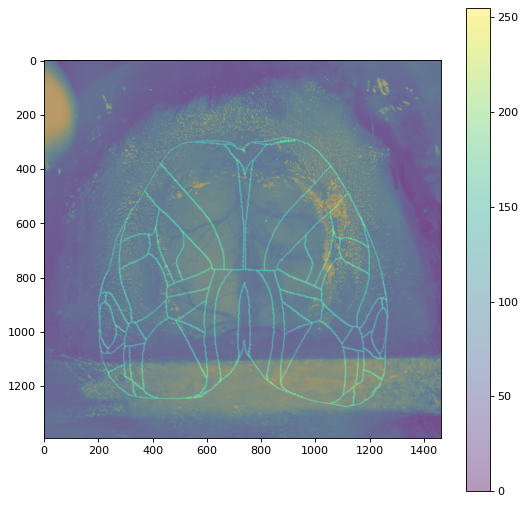

In [103]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 8), dpi=80)

plt.imshow(double_transformed_contour.numpy(), alpha=0.6)
plt.imshow(ants_window_image.numpy(), alpha=0.4)
plt.colorbar()
plt.show()

In [42]:
import numpy as np
from skimage.transform import AffineTransform

# Estimate the affine transformation
transform = AffineTransform()
transform.estimate(surgery_labels, window_labels)

# Apply the transformation to a point
transformed_points = transform(surgery_labels)

print(transformed_points)

[[ 690.27537024  957.51722597]
 [ 537.48465014  873.07353156]
 [ 679.74915915  583.27444681]
 [ 956.4016942   711.81509892]
 [ 578.32600398 1008.88783702]
 [ 768.76312229  640.43185972]]


# Tests to save masks

In [10]:
green_path = "/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Correction/corrected_green_movie.tif"

In [11]:
green_stack = tiff.imread(green_path)

In [20]:
green_stack.shape
window_image = np.flip(green_stack[0])

In [32]:
print(np.min(green_stack))
print(np.max(green_stack))

0
65535


# Tests with GUI that overlays two images

In [13]:
%matplotlib qt

import cv2
import numpy as np

img1 = cv2.imread('/Users/vincentchouinard/Documents/Maitrise/Registration/RS_M38_22aout/surgery.jpg')
img2 = cv2.imread('/Users/vincentchouinard/Documents/Maitrise/Data/RS_M38_22aout/Correction/corrected_green_movie.tif')
img2, _ , _ = intensity_bounds(img2)

def overlay(fixedimage_path, overlayimage_path):    
    
    # Create a window to display the images
    cv2.namedWindow('Image')

    # Initialize variables
    x_offset = 0
    y_offset = 0
    scale_percent = 100
    dragging = False
    resizing = False
    corner_size = 20



    # Define the mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal x_offset, y_offset, scale_percent, dragging, resizing

        if event == cv2.EVENT_LBUTTONDOWN:
            if x > x_offset - corner_size and x < x_offset + corner_size and y > y_offset - corner_size and y < y_offset + corner_size:
                resizing = True
            else:
                dragging = True
        elif event == cv2.EVENT_MOUSEMOVE:
            if dragging:
                x_offset += x - param[0]
                y_offset += y - param[1]
            elif resizing:
                scale_percent += (x - param[0]) / 10
        elif event == cv2.EVENT_LBUTTONUP:
            dragging = False
            resizing = False

        param[0] = x
        param[1] = y

    # Set the mouse callback function
    cv2.setMouseCallback('Image', mouse_callback, [0, 0])

    while True:
        # Resize img2
        width = int(img2.shape[1] * scale_percent / 100)
        height = int(img2.shape[0] * scale_percent / 100)
        dim = (width, height)
        resized_img2 = cv2.resize(img2, dim, interpolation = cv2.INTER_AREA)

        # Create the overlay image
        overlay = img1.copy()
        overlay[y_offset:y_offset+resized_img2.shape[0], x_offset:x_offset+resized_img2.shape[1]] = \
        cv2.addWeighted(overlay[y_offset:y_offset+resized_img2.shape[0], x_offset:x_offset+resized_img2.shape[1]], 0.5, resized_img2, 0.5, 0)

        # Draw the dots at the corners
        cv2.circle(overlay, (x_offset, y_offset), 5, (0, 0, 0), -1)

        # Show the image
        cv2.imshow('Image', overlay)

        # Break the loop when the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == 27:
            break



    # Release the resources and close the window
    cv2.destroyAllWindows()
    
    return x_offset, y_offset, scale_percent

x_offset, y_offset, scale_percent = overlay(img1, img2)

(760, 764)
(1378, 1208)


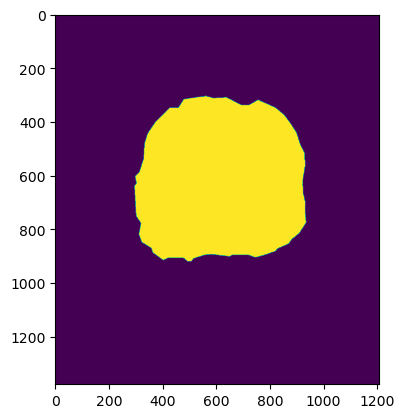

In [18]:
brain_mask = select_mask(np.copy(img2))

# calculate the new dimensions of the image
width = int(img2.shape[1] * scale_percent / 100)
height = int(img2.shape[0] * scale_percent / 100)
dim = (width, height)

resized = cv2.resize(brain_mask, dim, interpolation = cv2.INTER_LINEAR)

adjusted_brain_mask = np.zeros((img1.shape[0], img1.shape[1]))
adjusted_brain_mask[y_offset:y_offset + resized.shape[0], x_offset:x_offset + resized.shape[1]] = resized[:,:]

# plots the new brain mask adjusted to the dimensions of the surgery image.
%matplotlib inline

plt.imshow(adjusted_brain_mask)
plt.show()

In [22]:
print(width)

764


In [10]:
def crop_and_rescale(transformed_img, reference_img, x_offset, y_offset, scale_percent):
    # rescales images that are transformed and adjusted to masks in 1378 by 1208. That function goes in 
    # conjunction with the overlay function. reference_img is the wanted final dimensions. It is necessary
    # to have to descale.
    
    # calculate the new dimensions of the image
    upsized_width = int(reference_img.shape[1] * scale_percent / 100)
    upsized_height = int(reference_img.shape[0] * scale_percent / 100)
    upsized_dim = (upsized_width, upsized_height)
    
    # crops leftmost band and uppermost band to have no more offset.
    cropped_img = transformed_img[y_offset : y_offset+upsized_height , x_offset : x_offset+upsized_width]

    # rescales the image
    width = reference_img.shape[1]
    height = reference_img.shape[0]
    
    dim = (width, height)
    
    resized_img = cv2.resize(cropped_img, dim, interpolation = cv2.INTER_LINEAR)
    resized_img[resized_img > 0] = 1
    
    return resized_img

# Create mask folder and masks in .npy

In [100]:
def mask_folder(data_folder , mask_list, transform_list, overwrite = False):

    #Creates a folder in which movie is transformed to
    mask_folder_name = 'Masks'
    new_mask_path = "".join([data_folder,  '/', mask_folder_name])
    new_mask_path = Path(new_mask_path)

    if not os.path.exists(new_mask_path):
        os.makedirs(new_mask_path)

    new_mask_list = []
    masks = []
    
    for i in mask_list:
        if i != 0:
            file_path = new_mask_path / f'mask_{int(i)}.npy'
            if file_path.exists() and not overwrite:
                print(f"File {file_path} already exists and overwrite is set to False. Skipping.")
                continue
                
            mask = create_mask(isocortex_map, i)
            mask[mask != 0] = 1
            ants_mask = ants.from_numpy(mask, spacing=(25.,25.))
            transformed_mask = ants.apply_transforms(fixed=ants_surgery_mask,
                                                  moving=ants_mask,
                                                  transformlist=syn['fwdtransforms'])

            transformed_mask = transformed_mask*adjusted_brain_mask

            if len(np.unique(transformed_mask.numpy())) > 1:

                new_mask_list.append(int(i))
                numpy_transformed_mask = transformed_mask.numpy()
                numpy_transformed_mask[numpy_transformed_mask != 0] = 1

                # resize transformed_mask on right scale (the window scale):
                resized_transformed_mask = crop_and_rescale(numpy_transformed_mask, img2, x_offset, y_offset, scale_percent)
                
                
                # Adds the transformed mask to a list of masks that are not yet adjusted to not overlap.
                masks.append(resized_transformed_mask)
            else:
                continue
    
    # Obtains the overlap_map of all different transformed regions and segments them to assure no
    # overlapping.
    
    no_overlap_map = np.zeros((img2.shape[0],img2.shape[1]))
    
    for i in range(len(masks)):
        mask = masks[i]
        no_overlap_map += mask
        
    no_overlap_map[no_overlap_map > 1] = 0
    
    for i in range(len(masks)):
        mask = masks[i]*no_overlap_map
        np.save(new_mask_path, mask)
            
    print('Done!')
    return None

FileNotFoundError: [Errno 2] No such file or directory: '/Users/vincentchouinard/Documents/Maitrise/Registration/RS_M38_22aout/Masks/mask_281.npy'

In [ ]:
mask_folder

In [91]:
no_overlap_map = np.zeros((img2.shape[0],img2.shape[1]))
maskpath = "/Users/vincentchouinard/Documents/Maitrise/Registration/RS_M38_22aout/Masks"
for i in new_mask_list:
    if i != 0:
        i = int(i)
        mask = np.load(maskpath + '/mask_{}.npy'.format(i))
        no_overlap_map += mask
no_overlap_map[no_overlap_map > 1] = 0